# Project description:

In this project I am going to analyze data from the Department of Education, Training and Employment (DETE) and the Technical and Further Education (TAFE) institute in Queensland, Australia.  Data is provided as .csv in my repository. 

In this project, the aim is to answer the following questions:

+ Are employees who only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been there longer?
+ Are younger employees resigning due to some kind of dissatisfaction? What about older employees?

We need to combine the results for both surveys to answer these questions. However, although both used the same survey template, one of them customized some answers. Which requires data cleaning.

The data is contained in two different files. Each file represents a survey made by a different person. Even though both had the same template for the survey, some fields are different. In order to analyze all the data both datasets need to be merged.

## Importing the standard libraries

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

In [82]:
# This function modiefies the pandas dataframe style in a function so that dataframes can be displayed side by side. Taken from https://stackoverflow.com/a/68450201

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

## Reading the data - Initial try
> the dataset was previusly reencoded into UTF-8 to make things more simple to handle

In [83]:
dete_survey = pd.read_csv("dete_survey.csv") # No need to specify the encoding since UTF-8 is standard
tafe_survey = pd.read_csv("tafe_survey.csv")

## Getting an overall perception of the datasets

Let's take a look at the DETE dataset first.

In [84]:
# Relevant information for the DETE Dataset
dete_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   ID                                   822 non-null    int64 
 1   SeparationType                       822 non-null    object
 2   Cease Date                           822 non-null    object
 3   DETE Start Date                      822 non-null    object
 4   Role Start Date                      822 non-null    object
 5   Position                             817 non-null    object
 6   Classification                       455 non-null    object
 7   Region                               822 non-null    object
 8   Business Unit                        126 non-null    object
 9   Employment Status                    817 non-null    object
 10  Career move to public sector         822 non-null    bool  
 11  Career move to private sector        822 non-

One thing to notice is the amount of non-null objects present. Most of the Dataframe is made out of strings and probably qualitative data rather than measurements. There are also a great proportion of boolean values, that by looking at the column names categorize the employee.

In [85]:
# quick look at the dataset
dete_survey.head()

,ID,SeparationType,Cease Date,DETE Start Date,Role Start Date,Position,Classification,Region,Business Unit,Employment Status,...,Kept informed,Wellness programs,Health & Safety,Gender,Age,Aboriginal,Torres Strait,South Sea,Disability,NESB
0,1,Ill Health Retirement,08/2012,1984,2004,Public Servant,A01-A04,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,N,N,N,Male,56-60,NaN,NaN,NaN,NaN,Yes
1,2,Voluntary Early Retirement (VER),08/2012,Not Stated,Not Stated,Public Servant,AO5-AO7,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,N,N,N,Male,56-60,NaN,NaN,NaN,NaN,NaN
2,3,Voluntary Early Retirement (VER),05/2012,2011,2011,Schools Officer,NaN,Central Office,Education Queensland,Permanent Full-time,...,N,N,N,Male,61 or older,NaN,NaN,NaN,NaN,NaN
3,4,Resignation-Other reasons,05/2012,2005,2006,Teacher,Primary,Central Queensland,NaN,Permanent Full-time,...,A,N,A,Female,36-40,NaN,NaN,NaN,NaN,NaN
4,5,Age Retirement,05/2012,1970,1989,Head of Curriculum/Head of Special Education,NaN,South East,NaN,Permanent Full-time,...,N,A,M,Female,61 or older,NaN,NaN,NaN,NaN,NaN


In [86]:
display_side_by_side(
    [
        dete_survey.isnull().sum().sort_values(ascending= False).head(20).to_frame('Missing Values'), 
        dete_survey.isnull().sum().sort_values(ascending= True).head(20).to_frame('Missing Values')
    ], 
    ['top', 'bottom']
)

,Missing Values
Torres Strait,819
South Sea,815
Aboriginal,806
Disability,799
NESB,790
Business Unit,696
Classification,367
Opportunities for promotion,87
Career Aspirations,76
Wellness programs,56


Luckily there is no missing information in the `SeparationType`, `ID` ,`Cease Date` and `DETE Start` columns. From the other side, the columns with the most missing values seem to be very specific. Therefore, not all employees may belong here. E.g: 
The `Torres Strait` may contain probably information regarding if the employee comes or lives in the [Torres Strait Islands](https://en.wikipedia.org/wiki/Torres_Strait_Islands) or if the employee ethnicity is [Aboriginal](https://en.wikipedia.org/wiki/Aboriginal_Australians). Since there are a lot of NaN values we can assume that a small portion of the surveyed employees belong to these categories. Which at the same time could be one of the reasons for ending the employment. The other columns are mostly boolean, and show if the employee had extra possibilities like for example `Opportunities for promotion` or had some `Workplace issue`s in the past.

Let's take a look now at the TAFE dataset

In [87]:
# Relevant information for the TAFE Dataset
tafe_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 72 columns):
 #   Column                                                                                                                                                         Non-Null Count  Dtype  
---  ------                                                                                                                                                         --------------  -----  
 0   Record ID                                                                                                                                                      702 non-null    float64
 1   Institute                                                                                                                                                      702 non-null    object 
 2   WorkArea                                                                                                                                  

In [88]:
# quick look at the dataset
tafe_survey.head()

,Record ID,Institute,WorkArea,CESSATION YEAR,Reason for ceasing employment,Contributing Factors. Career Move - Public Sector,Contributing Factors. Career Move - Private Sector,Contributing Factors. Career Move - Self-employment,Contributing Factors. Ill Health,Contributing Factors. Maternity/Family,...,Workplace. Topic:Does your workplace promote a work culture free from all forms of unlawful discrimination?,Workplace. Topic:Does your workplace promote and practice the principles of employment equity?,Workplace. Topic:Does your workplace value the diversity of its employees?,Workplace. Topic:Would you recommend the Institute as an employer to others?,Gender. What is your Gender?,CurrentAge. Current Age,Employment Type. Employment Type,Classification. Classification,LengthofServiceOverall. Overall Length of Service at Institute (in years),LengthofServiceCurrent. Length of Service at current workplace (in years)
0,6.341330e+17,Southern Queensland Institute of TAFE,Non-Delivery (corporate),2010.0,Contract Expired,NaN,NaN,NaN,NaN,NaN,...,Yes,Yes,Yes,Yes,Female,26 30,Temporary Full-time,Administration (AO),1-2,1-2
1,6.341337e+17,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Retirement,-,-,-,-,-,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
2,6.341388e+17,Mount Isa Institute of TAFE,Delivery (teaching),2010.0,Retirement,-,-,-,-,-,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
3,6.341399e+17,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,-,-,-,-,-,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,6.341466e+17,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,Career Move - Private Sector,-,-,-,...,Yes,Yes,Yes,Yes,Male,41 45,Permanent Full-time,Teacher (including LVT),3-4,3-4


This dataset seems to be more specific regarding the survey questions. Here almost all data is stored in strings. The data that is supposed to be boolean, is represented as sting values in the "Yes/No Fashion". Which is not very usefull

In [89]:
display_side_by_side(
    [
        tafe_survey.isnull().sum().sort_values(ascending= False).head(10).to_frame('Missing Values'), 
        tafe_survey.isnull().sum().sort_values(ascending= True).head(10).to_frame('Missing Values')
    ], 
    ['top', 'bottom']
)

,Missing Values
Main Factor. Which of these was the main factor for leaving?,589
InductionInfo. Topic:Did you undertake a Corporate Induction?,270
Contributing Factors. Travel,265
Contributing Factors. Other,265
Contributing Factors. Career Move - Public Sector,265
Contributing Factors. Career Move - Private Sector,265
Contributing Factors. Career Move - Self-employment,265
Contributing Factors. Ill Health,265
Contributing Factors. Maternity/Family,265
Contributing Factors. Dissatisfaction,265


The TAFE survey seem to have more missing data, and seems more unstructured. Handling of missing values is often represented by a NAN or just a "-". But categorical data seems to have a constant format at least, see the Contributing Factors columns.

## Handling with missing data and reducing the dataset dimension to a relevant number of columns

+ The DETE survey dataframe contains 'Not Stated' values that indicate values are missing, but they aren't represented as NaN. The same happens for the TAFE survey with the '-' values. For this we will re-read the dataset but by specifying how some values may be transformed to NaN.
+ There are also some columns that may not be relevant for the analysis.


In [90]:
dete_survey = pd.read_csv("dete_survey.csv", na_values = "Not Stated") # Convert Not Stated to NaN

In [91]:
dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49], axis=1).copy()
# Drop columns that are not very relevant for the analysis

In [92]:
dete_survey.columns[28:49] # Removed Columns for DETE

Index(['Professional Development', 'Opportunities for promotion',
       'Staff morale', 'Workplace issue', 'Physical environment',
       'Worklife balance', 'Stress and pressure support',
       'Performance of supervisor', 'Peer support', 'Initiative', 'Skills',
       'Coach', 'Career Aspirations', 'Feedback', 'Further PD',
       'Communication', 'My say', 'Information', 'Kept informed',
       'Wellness programs', 'Health & Safety'],
      dtype='object')

For the DETE Dataset there are some columns that do not help us realize directly why the employee resigned. They still might be important and have any kind of influence, but this is harder to measure. Therefore, we choose those factors that are directly related with dissatisfaction in the workplace.

In [93]:
dete_survey_updated.columns # Kept columns for DETE

Index(['ID', 'SeparationType', 'Cease Date', 'DETE Start Date',
       'Role Start Date', 'Position', 'Classification', 'Region',
       'Business Unit', 'Employment Status', 'Career move to public sector',
       'Career move to private sector', 'Interpersonal conflicts',
       'Job dissatisfaction', 'Dissatisfaction with the department',
       'Physical work environment', 'Lack of recognition',
       'Lack of job security', 'Work location', 'Employment conditions',
       'Maternity/family', 'Relocation', 'Study/Travel', 'Ill Health',
       'Traumatic incident', 'Work life balance', 'Workload',
       'None of the above', 'Gender', 'Age', 'Aboriginal', 'Torres Strait',
       'South Sea', 'Disability', 'NESB'],
      dtype='object')

In [94]:
tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[17:66], axis=1).copy()
# Drop columns that are not very relevant for the analysis

In [95]:
tafe_survey.columns[17:66] # Removed Columns for TAFE

Index(['Main Factor. Which of these was the main factor for leaving?',
       'InstituteViews. Topic:1. I feel the senior leadership had a clear vision and direction',
       'InstituteViews. Topic:2. I was given access to skills training to help me do my job better',
       'InstituteViews. Topic:3. I was given adequate opportunities for personal development',
       'InstituteViews. Topic:4. I was given adequate opportunities for promotion within %Institute]Q25LBL%',
       'InstituteViews. Topic:5. I felt the salary for the job was right for the responsibilities I had',
       'InstituteViews. Topic:6. The organisation recognised when staff did good work',
       'InstituteViews. Topic:7. Management was generally supportive of me',
       'InstituteViews. Topic:8. Management was generally supportive of my team',
       'InstituteViews. Topic:9. I was kept informed of the changes in the organisation which would affect me',
       'InstituteViews. Topic:10. Staff morale was positive w

+ For the TAFE dataset we can do the same and see that there are a lot of columns which seem to be very subjective for the analysis. Here we also choose those that have mor clear information that led to a resignation.

In [96]:
tafe_survey_updated.columns# Kept Columns for TAFE

Index(['Record ID', 'Institute', 'WorkArea', 'CESSATION YEAR',
       'Reason for ceasing employment',
       'Contributing Factors. Career Move - Public Sector ',
       'Contributing Factors. Career Move - Private Sector ',
       'Contributing Factors. Career Move - Self-employment',
       'Contributing Factors. Ill Health',
       'Contributing Factors. Maternity/Family',
       'Contributing Factors. Dissatisfaction',
       'Contributing Factors. Job Dissatisfaction',
       'Contributing Factors. Interpersonal Conflict',
       'Contributing Factors. Study', 'Contributing Factors. Travel',
       'Contributing Factors. Other', 'Contributing Factors. NONE',
       'Gender. What is your Gender?', 'CurrentAge. Current Age',
       'Employment Type. Employment Type', 'Classification. Classification',
       'LengthofServiceOverall. Overall Length of Service at Institute (in years)',
       'LengthofServiceCurrent. Length of Service at current workplace (in years)'],
      dtype='ob

## Clean Column Names

There are some columns that have the same purpose between both datasets, but very different names. In order to merge this later on more easily we need to standardize the names of both.








| dete_survey     | tafe_survey                                                             | Definition                                              |
|-----------------|-------------------------------------------------------------------------|---------------------------------------------------------|
| ID              | Record ID                                                               | An id used to identify the participant of the survey    |
| SeparationType  | Reason for ceasingemployment                                            | The reason why the participant's employment ended       |
| Cease Date      | CESSATION YEAR                                                          | The year or month the participant's employment ended    |
| DETE Start Date |                                                                         | The year the participant began employment with the DETE |
|                 | LengthofServiceOverall.Overall Length of Serviceat Institute (in years) | The length of the person's employment (in years)        |
| Age             | CurrentAge.Current Age                                                  | The age of the participant                              |
| Gender          | Gender.What is your Gender?                                             | The gender of the participant                           |

For the **DETE** dataset the columns names are quite good, and we can just format them to be more consistent, by using the `Series.str` accessor over the `DataFrame.columns` Series object.

In [97]:
dete_survey_updated.columns = dete_survey_updated.columns.str.replace(' ', '_').str.lower().str.strip()

In [98]:
dete_survey_updated.columns # New DETE column names

Index(['id', 'separationtype', 'cease_date', 'dete_start_date',
       'role_start_date', 'position', 'classification', 'region',
       'business_unit', 'employment_status', 'career_move_to_public_sector',
       'career_move_to_private_sector', 'interpersonal_conflicts',
       'job_dissatisfaction', 'dissatisfaction_with_the_department',
       'physical_work_environment', 'lack_of_recognition',
       'lack_of_job_security', 'work_location', 'employment_conditions',
       'maternity/family', 'relocation', 'study/travel', 'ill_health',
       'traumatic_incident', 'work_life_balance', 'workload',
       'none_of_the_above', 'gender', 'age', 'aboriginal', 'torres_strait',
       'south_sea', 'disability', 'nesb'],
      dtype='object')

Since I decided that the **DETE** dataset columns names are going to be the standard ones, we need to rename the **TAFE** columns according to these. Here the `DataFrame.rename()` method works better for an explicit mapping of the new names over the old names. We create a mapping dictionary to make the function more readable

In [99]:
mapping_dic = {'Record ID': 'id',
               'CESSATION YEAR': 'cease_date',
               'Reason for ceasing employment': 'separationtype',
               'Gender. What is your Gender?': 'gender',
               'CurrentAge. Current Age': 'age',
               'Employment Type. Employment Type': 'employment_status',
               'Classification. Classification': 'position', 
               'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service',
               'LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'}
                # Mapping dictionary, can be extended... 

tafe_survey_updated = tafe_survey_updated.rename(mapper=mapping_dic,axis=1)

In [100]:
tafe_survey_updated.columns # New TAFE column names

Index(['id', 'Institute', 'WorkArea', 'cease_date', 'separationtype',
       'Contributing Factors. Career Move - Public Sector ',
       'Contributing Factors. Career Move - Private Sector ',
       'Contributing Factors. Career Move - Self-employment',
       'Contributing Factors. Ill Health',
       'Contributing Factors. Maternity/Family',
       'Contributing Factors. Dissatisfaction',
       'Contributing Factors. Job Dissatisfaction',
       'Contributing Factors. Interpersonal Conflict',
       'Contributing Factors. Study', 'Contributing Factors. Travel',
       'Contributing Factors. Other', 'Contributing Factors. NONE', 'gender',
       'age', 'employment_status', 'position', 'institute_service',
       'role_service'],
      dtype='object')

## Filtering the data

Are employees who have only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been at the job longer?

This is our main question to answer so therefore we will be interested only on those employees that resigned, on the `separationtype` column. That is our 1st Filter criteria.

In [101]:
display_side_by_side(
    [
        dete_survey_updated["separationtype"].value_counts().to_frame('Frecuency'), 
        tafe_survey_updated["separationtype"].value_counts().to_frame('Frecuency')
    ], 
    ['DETE', 'TAFE']
)

,Frecuency
Age Retirement,285
Resignation-Other reasons,150
Resignation-Other employer,91
Resignation-Move overseas/interstate,70
Voluntary Early Retirement (VER),67
Ill Health Retirement,61
Other,49
Contract Expired,34
Termination,15
,Frecuency


Looking at both datasets, we see that some fields in the DETE dataset can be combined E.g. the Resignation variable is specified further. In order to consolidate these to just Resignation, these variables have to be modified. This can be achieved with the `.str.split` accessor-method on the `-`character and pulling the first element in the resulting list, which is the word `Resignation`. 

In [102]:
dete_survey_updated['separationtype'] = dete_survey_updated['separationtype'].str.split('-').str[0]

# Check the values in the separationtype column were updated correctly
display_side_by_side(
    [
        dete_survey_updated["separationtype"].value_counts().to_frame('Frecuency'), 
        tafe_survey_updated["separationtype"].value_counts().to_frame('Frecuency')
    ], 
    ['DETE', 'TAFE']
)

,Frecuency
Resignation,311
Age Retirement,285
Voluntary Early Retirement (VER),67
Ill Health Retirement,61
Other,49
Contract Expired,34
Termination,15
,Frecuency
Resignation,340
Contract Expired,127


Since for answering the question: Are employees who have only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been on the job longer? Only the subset of people who resigned is analyzed, a new dataframe containing only that data can be created.

In [104]:
dete_resignations = dete_survey_updated[dete_survey_updated['separationtype'] == 'Resignation'].copy()
tafe_resignations = tafe_survey_updated[tafe_survey_updated["separationtype"] == 'Resignation'].copy()

# Only showing the first 5 rows and columns for comparison
display_side_by_side(
    [
        dete_resignations.iloc[:5,:5], 
        tafe_resignations.iloc[:5,:5]
    ], 
    ['DETE', 'TAFE']
)

,id,separationtype,cease_date,dete_start_date,role_start_date
3,4,Resignation,05/2012,2005.000000,2006.000000
5,6,Resignation,05/2012,1994.000000,1997.000000
8,9,Resignation,07/2012,2009.000000,2009.000000
9,10,Resignation,2012,1997.000000,2008.000000
11,12,Resignation,2012,2009.000000,2009.000000
,id,Institute,WorkArea,cease_date,separationtype
3,634139903350000000.000000,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.000000,Resignation
4,634146578511788032.000000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.000000,Resignation
5,634147506906311040.000000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.000000,Resignation
6,634152007975693952.000000,Barrier Reef Institute of TAFE,Non-Delivery (corporate),2010.000000,Resignation


In [35]:
dete_resignations["cease_date"].value_counts()

2012       126
2013        74
01/2014     22
12/2013     17
06/2013     14
09/2013     11
11/2013      9
07/2013      9
10/2013      6
08/2013      4
05/2013      2
05/2012      2
07/2006      1
2010         1
07/2012      1
09/2010      1
Name: cease_date, dtype: int64

In [36]:
# pattern = '(?P<Years>[1-2][0-9]{3})'

# extracted_years = dete_resignations["cease_date"].str.extract(pattern)

# dete_resignations["cease_date"] = extracted_years.astype("float").copy()


# Extract the years and convert them to a float type
dete_resignations['cease_date'] = dete_resignations['cease_date'].str.split('/').str[-1]
dete_resignations['cease_date'] = dete_resignations['cease_date'].astype("float")



In [38]:

dete_resignations.isna().sum()

id                                       0
separationtype                           0
cease_date                              11
dete_start_date                         28
role_start_date                         40
position                                 3
classification                         150
region                                  46
business_unit                          279
employment_status                        4
career_move_to_public_sector             0
career_move_to_private_sector            0
interpersonal_conflicts                  0
job_dissatisfaction                      0
dissatisfaction_with_the_department      0
physical_work_environment                0
lack_of_recognition                      0
lack_of_job_security                     0
work_location                            0
employment_conditions                    0
maternity/family                         0
relocation                               0
study/travel                             0
ill_health 

In [ ]:
dete_resignation["cease_date"].value_counts()

2013.0    146
2012.0    129
2014.0     22
2010.0      2
2006.0      1
Name: cease_date, dtype: int64

In [ ]:
dete_resignation["dete_start_date"].value_counts()

2011.0    24
2008.0    22
2007.0    21
2012.0    21
2010.0    17
2005.0    15
2004.0    14
2009.0    13
2006.0    13
2013.0    10
2000.0     9
1999.0     8
1996.0     6
2002.0     6
1992.0     6
1998.0     6
2003.0     6
1994.0     6
1993.0     5
1990.0     5
1980.0     5
1997.0     5
1991.0     4
1989.0     4
1988.0     4
1995.0     4
2001.0     3
1985.0     3
1986.0     3
1983.0     2
1976.0     2
1974.0     2
1971.0     1
1972.0     1
1984.0     1
1982.0     1
1987.0     1
1975.0     1
1973.0     1
1977.0     1
1963.0     1
Name: dete_start_date, dtype: int64

In [ ]:
tafe_resignations["cease_date"].value_counts(ascending = False)

2011.0    116
2012.0     94
2010.0     68
2013.0     55
2009.0      2
Name: cease_date, dtype: int64

### Create a new column

In [ ]:
dete_resignations["institute_service"] = dete_resignations["cease_date"] - dete_resignations["dete_start_date"]

In [ ]:
dete_resignations["institute_service"].value_counts(dropna=False)

NaN     38
5.0     23
1.0     22
3.0     20
0.0     20
6.0     17
4.0     16
9.0     14
2.0     14
7.0     13
13.0     8
8.0      8
20.0     7
15.0     7
12.0     6
22.0     6
17.0     6
10.0     6
14.0     6
16.0     5
18.0     5
24.0     4
23.0     4
11.0     4
39.0     3
32.0     3
19.0     3
21.0     3
36.0     2
30.0     2
25.0     2
28.0     2
26.0     2
29.0     1
42.0     1
38.0     1
27.0     1
41.0     1
35.0     1
49.0     1
34.0     1
33.0     1
31.0     1
Name: institute_service, dtype: int64

### Identify Dissatiesfied Employees

In [ ]:
#tafe_resignations['Contributing Factors. Dissatisfaction'] = tafe_resignations['Contributing Factors. Dissatisfaction'].replace({"Contributing Factors. Dissatisfaction ": True, "-" :np.nan}).copy()

#tafe_resignations['Contributing Factors. Job Dissatisfaction'] = tafe_resignations['Contributing Factors. Job Dissatisfaction'].replace({"Job Dissatisfaction": True, "-" :np.nan}).copy()


### Way 2

In [ ]:
 def update_vals(val):
        if pd.isnull(val):
            return np.nan
        elif val == "-":
            return False
        else:
            return True
            

In [ ]:
tafe_resignations["dissatisfied"] = tafe_resignations[['Contributing Factors. Dissatisfaction','Contributing Factors. Job Dissatisfaction']].applymap(update_vals).any(axis=1,skipna=False)

In [ ]:
tafe_resignations_up = tafe_resignations.copy()
# Check the unique values after the updates
tafe_resignations_up['dissatisfied'].value_counts(dropna=False)

False    241
True      91
NaN        8
Name: dissatisfied, dtype: int64

In [ ]:
dete_resignations['dissatisfied'] = dete_resignations[['job_dissatisfaction',
       'dissatisfaction_with_the_department', 'physical_work_environment',
       'lack_of_recognition', 'lack_of_job_security', 'work_location',
       'employment_conditions', 'work_life_balance',
       'workload']].any(1, skipna=False)
dete_resignations_up = dete_resignations.copy()
dete_resignations_up['dissatisfied'].value_counts(dropna=False)

False    162
True     149
Name: dissatisfied, dtype: int64

### Combine the Data

In [ ]:
dete_resignations_up["institute"] = "DETE"
tafe_resignations_up["institute"] = "TAFE"

In [ ]:
combined = pd.concat([dete_resignations_up, tafe_resignations_up], ignore_index=True, sort= False)
combined.notnull().sum().sort_values()

torres_strait                                            0
south_sea                                                3
aboriginal                                               7
disability                                               8
nesb                                                     9
business_unit                                           32
classification                                         161
region                                                 265
role_start_date                                        271
dete_start_date                                        283
role_service                                           290
none_of_the_above                                      311
work_life_balance                                      311
traumatic_incident                                     311
ill_health                                             311
study/travel                                           311
relocation                                             3

In [ ]:
combined_updated = combined.dropna(axis=1, thresh=500).copy()


In [ ]:
combined_updated.shape

(651, 10)

In [ ]:
combined_updated.head()

,id,separationtype,cease_date,position,employment_status,gender,age,institute_service,dissatisfied,institute
0,4.0,Resignation,2012.0,Teacher,Permanent Full-time,Female,36-40,7,False,DETE
1,6.0,Resignation,2012.0,Guidance Officer,Permanent Full-time,Female,41-45,18,True,DETE
2,9.0,Resignation,2012.0,Teacher,Permanent Full-time,Female,31-35,3,False,DETE
3,10.0,Resignation,2012.0,Teacher Aide,Permanent Part-time,Female,46-50,15,True,DETE
4,12.0,Resignation,2012.0,Teacher,Permanent Full-time,Male,31-35,3,False,DETE


In [ ]:
combined_updated["institute_service"].value_counts()

Less than 1 year      73
1-2                   64
3-4                   63
5-6                   33
11-20                 26
5.0                   23
1.0                   22
7-10                  21
3.0                   20
0.0                   20
6.0                   17
4.0                   16
9.0                   14
2.0                   14
7.0                   13
More than 20 years    10
13.0                   8
8.0                    8
20.0                   7
15.0                   7
14.0                   6
17.0                   6
12.0                   6
10.0                   6
22.0                   6
18.0                   5
16.0                   5
24.0                   4
23.0                   4
11.0                   4
39.0                   3
19.0                   3
21.0                   3
32.0                   3
36.0                   2
25.0                   2
26.0                   2
28.0                   2
30.0                   2
42.0                   1


In [ ]:
combined_updated["institute_service"] = combined_updated["institute_service"].astype("str").str.extract(r'(\d+)').astype("float")

### Clean the Service Column

In [ ]:
def check_range(val):
    if val >= 11:
        return "Veteran"
    elif 7 <= val < 11:
        return "Established"
    elif 3 <= val < 7:
        return "Experienced"
    elif pd.isnull(val):
        return np.nan
    else:
        return "New"
  

In [ ]:
combined_updated["service_cat"]=combined_updated["institute_service"].apply(check_range)

combined_updated["service_cat"].value_counts()

New            193
Experienced    172
Veteran        136
Established     62
Name: service_cat, dtype: int64

### Perform initial analysis

In [ ]:
combined_updated["dissatisfied"].value_counts(dropna = False)

False    411
True     240
Name: dissatisfied, dtype: int64

In [ ]:
combined_updated["dissatisfied"] = combined_updated["dissatisfied"].fillna(value = False)

In [ ]:
combined_pivot = combined_updated.pivot_table(values="dissatisfied", index="service_cat")

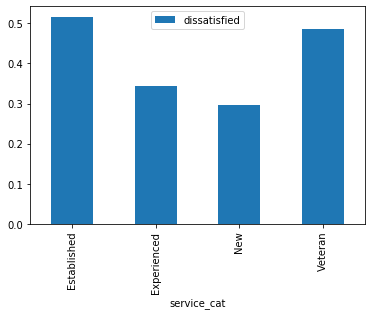

In [ ]:
combined_pivot.plot(kind="bar")